# Projeto - ANÁLISE DE TEXTO DE FONTES DESESTRUTURADAS E WEB 

## Análise dos dados imobiliários de São Paulo a partir de dados do site Quinto Andar

Feito por: Augusto Carneiro, Guilherme Rameh - 05/2024

------

## Proposta:

A partir do enunciado do projeto, o grupo se propõe a coletar dados por meio de web scrapping no site "Quinto Andar", e analisar o cenário imobilipario de São Paulo a partir deles.

## Coleta dos Dados
A página principal de busca de apartamentos do Quinto Andar lista apartamentos disponíveis, mas se você não clicar nele, faltam informações que achamos importantes. Assim, primeiro salvaremos o máximo de links para apartamentos possíveis, e então acessamos cada um para pegar as informações que queremos usar. Essas informações são transformadas em um DataFrame da biblioteca Pandas, e salvo em um arquivo do tipo *parquet* para não precisarmos executar a busca de dados a cada inicialização deste arquivo.

In [3]:
from selenium import webdriver
from selenium.common.exceptions import StaleElementReferenceException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
driver = webdriver.Chrome(options=chrome_options)
driver.set_page_load_timeout(60)
url = 'https://www.quintoandar.com.br/alugar/imovel/sao-paulo-sp-brasil'

In [4]:
driver.get(url)
driver.implicitly_wait(10)

wait = WebDriverWait(driver, timeout=5)

Na célula abaixo, a busca e armazenamento dos links de cada apartamento. Isso é necessário pois clicamos no botão de "mostrar mais" para obtermos apartamentos antes inacessíveis.

In [12]:
horas = []

for i in range(100):
    try:
        horas = driver.find_elements(By.XPATH, '//main/section[2]/div/div')
        wait.until(EC.element_to_be_clickable((By.XPATH, '//main/section[2]/div/div[last()-2]/button')))
        horas[-3].click()
        wait.until(EC.staleness_of(horas[-3]))

    except Exception as err:
        print(f'\nse fudeu em {i}: {err = }\n')

        if isinstance(err, StaleElementReferenceException):
            print("Attempting to recover from StaleElementReferenceException")
            wait.until(EC.element_to_be_clickable((By.XPATH, '//main/section[2]/div/div[last()-2]/button')))
        else:
            raise err

    print(f'list size on iteration {i}: {len(horas)}')

list size on iteration 0: 2140
list size on iteration 1: 2152
list size on iteration 2: 2164
list size on iteration 3: 2176
list size on iteration 4: 2188
list size on iteration 5: 2200
list size on iteration 6: 2212
list size on iteration 7: 2224
list size on iteration 8: 2236
list size on iteration 9: 2248
list size on iteration 10: 2260
list size on iteration 11: 2272
list size on iteration 12: 2284
list size on iteration 13: 2296
list size on iteration 14: 2308
list size on iteration 15: 2320
list size on iteration 16: 2332
list size on iteration 17: 2344
list size on iteration 18: 2356
list size on iteration 19: 2368
list size on iteration 20: 2380
list size on iteration 21: 2392
list size on iteration 22: 2404
list size on iteration 23: 2416
list size on iteration 24: 2428


KeyboardInterrupt: 

In [13]:
links = []
# os divs de interesse vao desde o segundo ate o anteantepenultimo
for i, div in enumerate(horas[1:-4]):
    current_link = div.find_element(by=By.TAG_NAME, value='a').get_property('href')
    print(f'link at iteration {i} {current_link}')
    links.append(current_link)

link at iteration 0 https://www.quintoandar.com.br/imovel/892968755/alugar/casa-2-quartos-sao-joao-climaco-sao-paulo?from_route=%22search_results%22&house_tags=exclusivity&house_tags=rentPriceDecreased&search_id=%227f8d8697-487c-421d-8f6a-9f53480693a6%22&search_rank=%7B%22sortMode%22%3A%22relevance%22%2C%22searchMode%22%3A%22list%22%2C%22resultsOrigin%22%3A%22search%22%2C%22rank%22%3A0%2C%22personalization%22%3Atrue%7D
link at iteration 1 https://www.quintoandar.com.br/imovel/893435980/alugar/apartamento-2-quartos-jurubatuba-sao-paulo?from_route=%22search_results%22&house_tags=exclusivity&search_id=%227f8d8697-487c-421d-8f6a-9f53480693a6%22&search_rank=%7B%22sortMode%22%3A%22relevance%22%2C%22searchMode%22%3A%22list%22%2C%22resultsOrigin%22%3A%22search%22%2C%22rank%22%3A1%2C%22personalization%22%3Atrue%7D
link at iteration 2 https://www.quintoandar.com.br/imovel/893535263/alugar/kitnet-1-quarto-campos-eliseos-sao-paulo?from_route=%22search_results%22&house_tags=exclusivity&search_id=%2

para cada link, obter aas informações de interesse e guardar em um DF

In [14]:
data_info = {
    'suite_area'    : {
        'xpath' : '//main/section/div/div[1]/div/div[3]/section/div/div[3]/div/div/div[1]/div/div/p',
        'type'  : 'numeric'
    },
    'street'        : {
        'xpath' : '//main/section/div/div[1]/div/div[2]/div/div/div/div[1]/div/h4',
        'type'  : 'text'
    },
    'neighborhood'  : {
        'xpath' : '//main/section/div/div[1]/div/div[2]/div/div/div/div[1]/small',
        'type'  : 'text'
    },
    'condominium'   : {
        'xpath' : '//main/section/div/div[1]/div/div[3]/section/div/div[2]/div/ul/li[2]/div/div/p',
        'type'  : 'numeric'
    },
    'tax'           : {
        'xpath' : '//main/section/div/div[1]/div/div[3]/section/div/div[2]/div/ul/li[3]/div/div/p',
        'type'  : 'numeric'
    },
    'asking_price'  : {
        'xpath' : '//main/section/div/div[1]/div/div[3]/section/div/div[2]/div/ul/li[1]/div/div/p',
        'type'  : 'numeric'
    }
}

In [16]:
import pandas as pd


delta_y = 800
stock = []

for i, link in enumerate(links):
    driver.get(link)
    driver.implicitly_wait(10)
    ActionChains(driver) \
        .scroll_by_amount(0, delta_y) \
        .perform()

    try:
        raw_suite_data = {
            key: driver.find_element(by=By.XPATH, value=info['xpath']).text for key, info in data_info.items()
        }

        print(f'raw data on iteration {i} {raw_suite_data}')
        
        treated_suite_data = {
            key: int('0'+''.join(filter(str.isdecimal, value))) if data_info[key]['type'] == 'numeric' else value for key, value in raw_suite_data.items()
        }
        
        print(f'treated data on iteration {i} {treated_suite_data}')
        
        stock.append(treated_suite_data)
    except: continue

raw data on iteration 0 {'suite_area': '70 m²', 'street': 'Rua Lamute', 'neighborhood': 'São João Clímaco, São Paulo', 'condominium': 'R$ 0', 'tax': 'R$ 59', 'asking_price': 'R$ 1.100'}
treated data on iteration 0 {'suite_area': 70, 'street': 'Rua Lamute', 'neighborhood': 'São João Clímaco, São Paulo', 'condominium': 0, 'tax': 59, 'asking_price': 1100}
raw data on iteration 1 {'suite_area': '34 m²', 'street': 'Rua Galeno de Castro', 'neighborhood': 'Jurubatuba, São Paulo', 'condominium': 'R$ 0', 'tax': 'R$ 0', 'asking_price': 'R$ 2.725'}
treated data on iteration 1 {'suite_area': 34, 'street': 'Rua Galeno de Castro', 'neighborhood': 'Jurubatuba, São Paulo', 'condominium': 0, 'tax': 0, 'asking_price': 2725}
raw data on iteration 2 {'suite_area': '12 m²', 'street': 'Alameda Nothmann', 'neighborhood': 'Campos Elíseos, São Paulo', 'condominium': 'R$ 150', 'tax': 'R$ 69', 'asking_price': 'R$ 1.515'}
treated data on iteration 2 {'suite_area': 12, 'street': 'Alameda Nothmann', 'neighborhood':

In [17]:
df = pd.DataFrame(stock)
df

,suite_area,street,neighborhood,condominium,tax,asking_price
0,70,Rua Lamute,"São João Clímaco, São Paulo",0,59,1100
1,34,Rua Galeno de Castro,"Jurubatuba, São Paulo",0,0,2725
2,12,Alameda Nothmann,"Campos Elíseos, São Paulo",150,69,1515
3,33,Rua Luís Correia de Melo,"Santo Amaro, São Paulo",506,91,2700
4,104,Rua Jorge Rizzo,"Pinheiros, São Paulo",1680,0,5600
...,...,...,...,...,...,...
2408,29,Rua Eleutério,"Campo Belo, São Paulo",355,25,2868
2409,25,Rua General Jardim,"Vila Buarque, São Paulo",550,0,1950
2410,99,Rua Paulo de Avelar,"Vila Dom Pedro Ii, São Paulo",150,0,3100
2411,100,Avenida Leonardo da Vinci,"Vila Guarani (z Sul), São Paulo",0,0,3500


In [18]:
df.to_parquet('stock.parquet')

## Análise dos dados

Agora exploraremos os dados que conseguimos, analisando relação entre localidade, preço do metro quadrado e ???

Começamos lendo o arquivo de dados:

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
df = pd.read_parquet('stock.parquet')
df

,suite_area,street,neighborhood,condominium,tax,asking_price
0,70,Rua Lamute,"São João Clímaco, São Paulo",0,59,1100
1,34,Rua Galeno de Castro,"Jurubatuba, São Paulo",0,0,2725
2,12,Alameda Nothmann,"Campos Elíseos, São Paulo",150,69,1515
3,33,Rua Luís Correia de Melo,"Santo Amaro, São Paulo",506,91,2700
4,104,Rua Jorge Rizzo,"Pinheiros, São Paulo",1680,0,5600
...,...,...,...,...,...,...
2408,29,Rua Eleutério,"Campo Belo, São Paulo",355,25,2868
2409,25,Rua General Jardim,"Vila Buarque, São Paulo",550,0,1950
2410,99,Rua Paulo de Avelar,"Vila Dom Pedro Ii, São Paulo",150,0,3100
2411,100,Avenida Leonardo da Vinci,"Vila Guarani (z Sul), São Paulo",0,0,3500


Verificamos se existem entradas duplicadas

In [34]:
df[df.duplicated(keep=False)]

,suite_area,street,neighborhood,condominium,tax,asking_price


In [33]:
df.drop_duplicates(inplace=True)

Aqui verificamos a escrita dos bairros. Percebemos que algumas entradas diferentes eram causadas por entradas com e sem acentos, como "America" e "América". Usamos a biblioteca *Levenshtein* para identificar entradas com diferença de 1 ou dois caracteres, e usamos do input do usuário para definir qual estpa certo e alterá-lo no df original. Há casos que ambôs estão corretos, e para isso, lidamos com um terceiro input que pula aquela alteração, e mantém ambas as entradas.

In [41]:
import Levenshtein

neighborhood_names = df['neighborhood'].unique()

similar_neighborhoods = []
already_checked = []

In [45]:
for i in range(len(neighborhood_names)):
    for j in range(i+1, len(neighborhood_names)):
        distance = Levenshtein.distance(neighborhood_names[i], neighborhood_names[j])
        if distance <= 2:
            similar_neighborhoods.append((neighborhood_names[i], neighborhood_names[j]))

for neighborhood_pair in similar_neighborhoods:
    if neighborhood_pair in already_checked:
        continue
    print(neighborhood_pair)
    user_input = input("Which neighborhood is correct? Enter the correct neighborhood name: ")
    if user_input == "":
        break
    else :
        user_input = int(user_input)
    correct_neighborhood = neighborhood_pair[0] if user_input==1 else neighborhood_pair[1] if user_input == 2 else None
    wrong_neighborhood = neighborhood_pair[1] if neighborhood_pair[0] == correct_neighborhood else neighborhood_pair[0]
    if correct_neighborhood:
        print(f"Corrigindo {wrong_neighborhood} para {correct_neighborhood}...")
        df.loc[df['neighborhood'] == wrong_neighborhood, 'neighborhood'] = correct_neighborhood
    else:
        print("Invalid input. Skipping...")
        already_checked.append(neighborhood_pair)

('Jardim Dracena, São Paulo', 'Jardim Iracema, São Paulo')
Invalid input. Skipping...


<AxesSubplot: xlabel='neighborhood'>

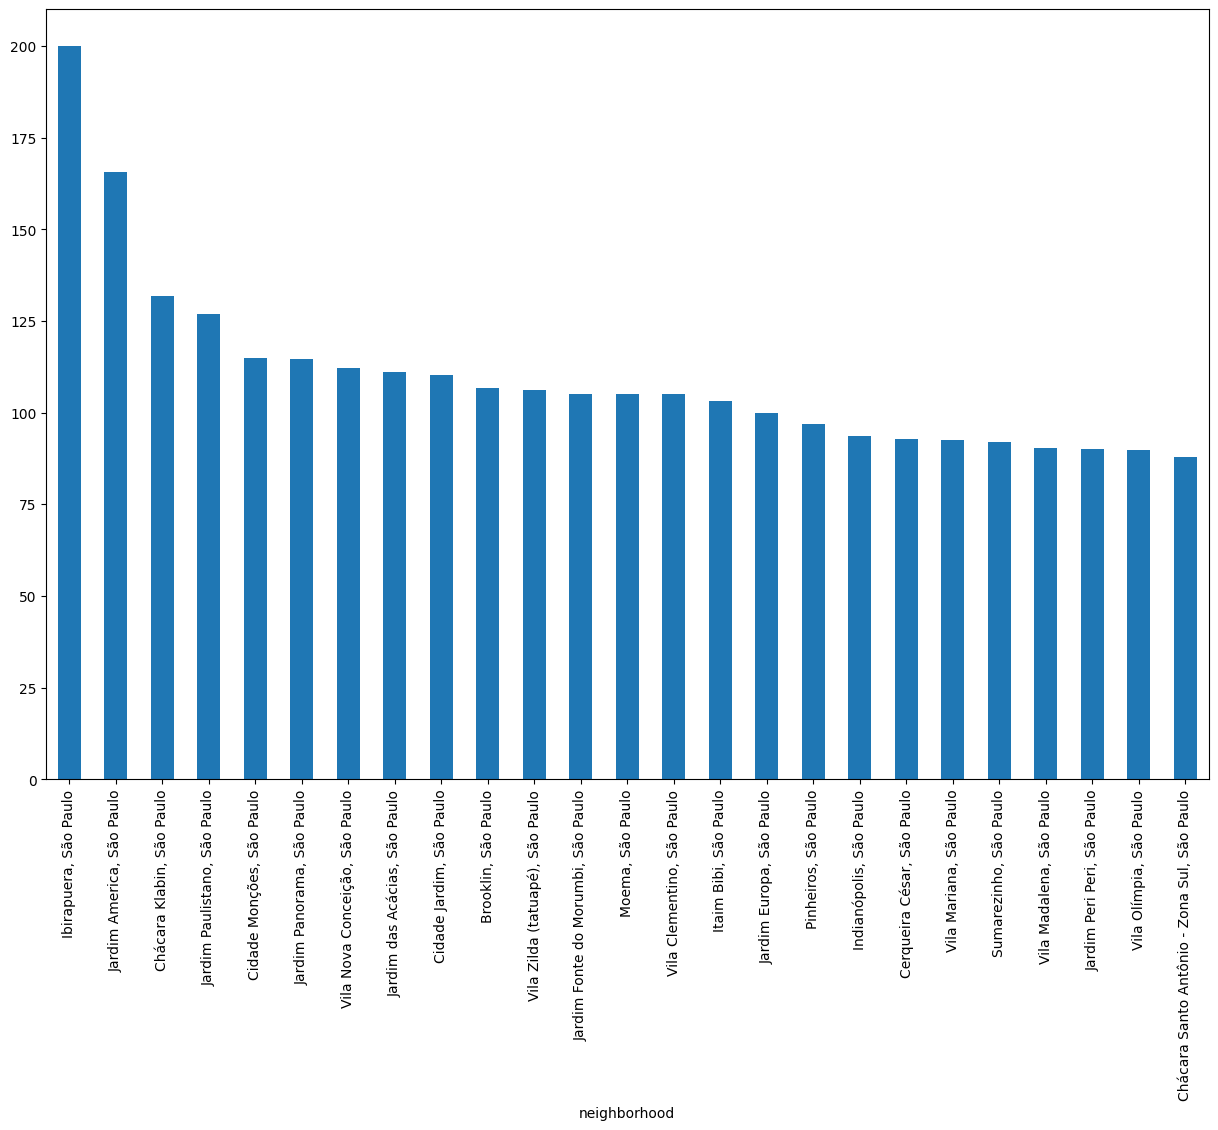

In [58]:
df['price_per_sqm'] = df['asking_price'] / df['suite_area']
neighborhood_avg_price = df.groupby('neighborhood')['price_per_sqm'].mean()
neighborhood_avg_price.sort_values(ascending=False).head(25).plot(kind='bar', figsize=(15, 10))